# Invoice Digitization Playground

Let's build a workflow to upload a PDF file to a S3 Bucket and parse this file to an Excel file to have it available with the key information. 
The workflow works as follows: 

S3 Bucket upload (.pdf) --> Trigger Lambda Function --> Lambda Processes Requests and dumps .xlsx --> Dump .xlsx file to S3 parsed folder


Before we can install all the relevant lbraries it is important to download the [Pytesseract Binaries](https://digi.bib.uni-mannheim.de/tesseract/), which come with a launch wizard. <br>
Now we can move on with the normal installations <br>
Installations: <br>

pip install numpy<br>
pip install pandas<br>
pip install pdf2image<br>
pip install cv2<br>
pip install pytesseract<br>

In [6]:
import os
import cv2 # optional only for visualization purposes
import pdf2image
import pandas as pd 
import numpy as np 
import pytesseract
from importlib.metadata import version
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
pytesseract.pytesseract.tesseract_cmd = "C:\\Users\\lehmanl\\AppData\\Local\\Programs\\Tesseract-OCR\\tesseract.exe"

In [2]:
def extractCharBlock(block, keyWord, end=-1):
    response = block[ (block.find(keyWord) + len(keyWord)) : end]
    return response

In [ ]:
version('openpyxl')

## Reading the PDF Invoices

go through all the files in the *Invoice* folder and load them into the files variable

In [3]:
fileDir = os.path.join(os.getcwd(), 'Invoice')
files = []
imgPath = []
for file in os.listdir(fileDir):
    if file.endswith('.pdf'):
        files.append(os.path.join(fileDir, file))
    else: #endswith .jpg
        imgPath.append(os.path.join(fileDir, file))
files

['C:\\Users\\lehmanl\\Documents\\Python\\invoiceDigitization\\Invoice\\NZBAWG.pdf',
 'C:\\Users\\lehmanl\\Documents\\Python\\invoiceDigitization\\Invoice\\W79DK1.pdf',
 'C:\\Users\\lehmanl\\Documents\\Python\\invoiceDigitization\\Invoice\\ZL4P12.pdf']

In [4]:
files[1].split('\\')[-1][:-4]

'W79DK1'

## Convert PDFs to Images (.jpg) to work with them

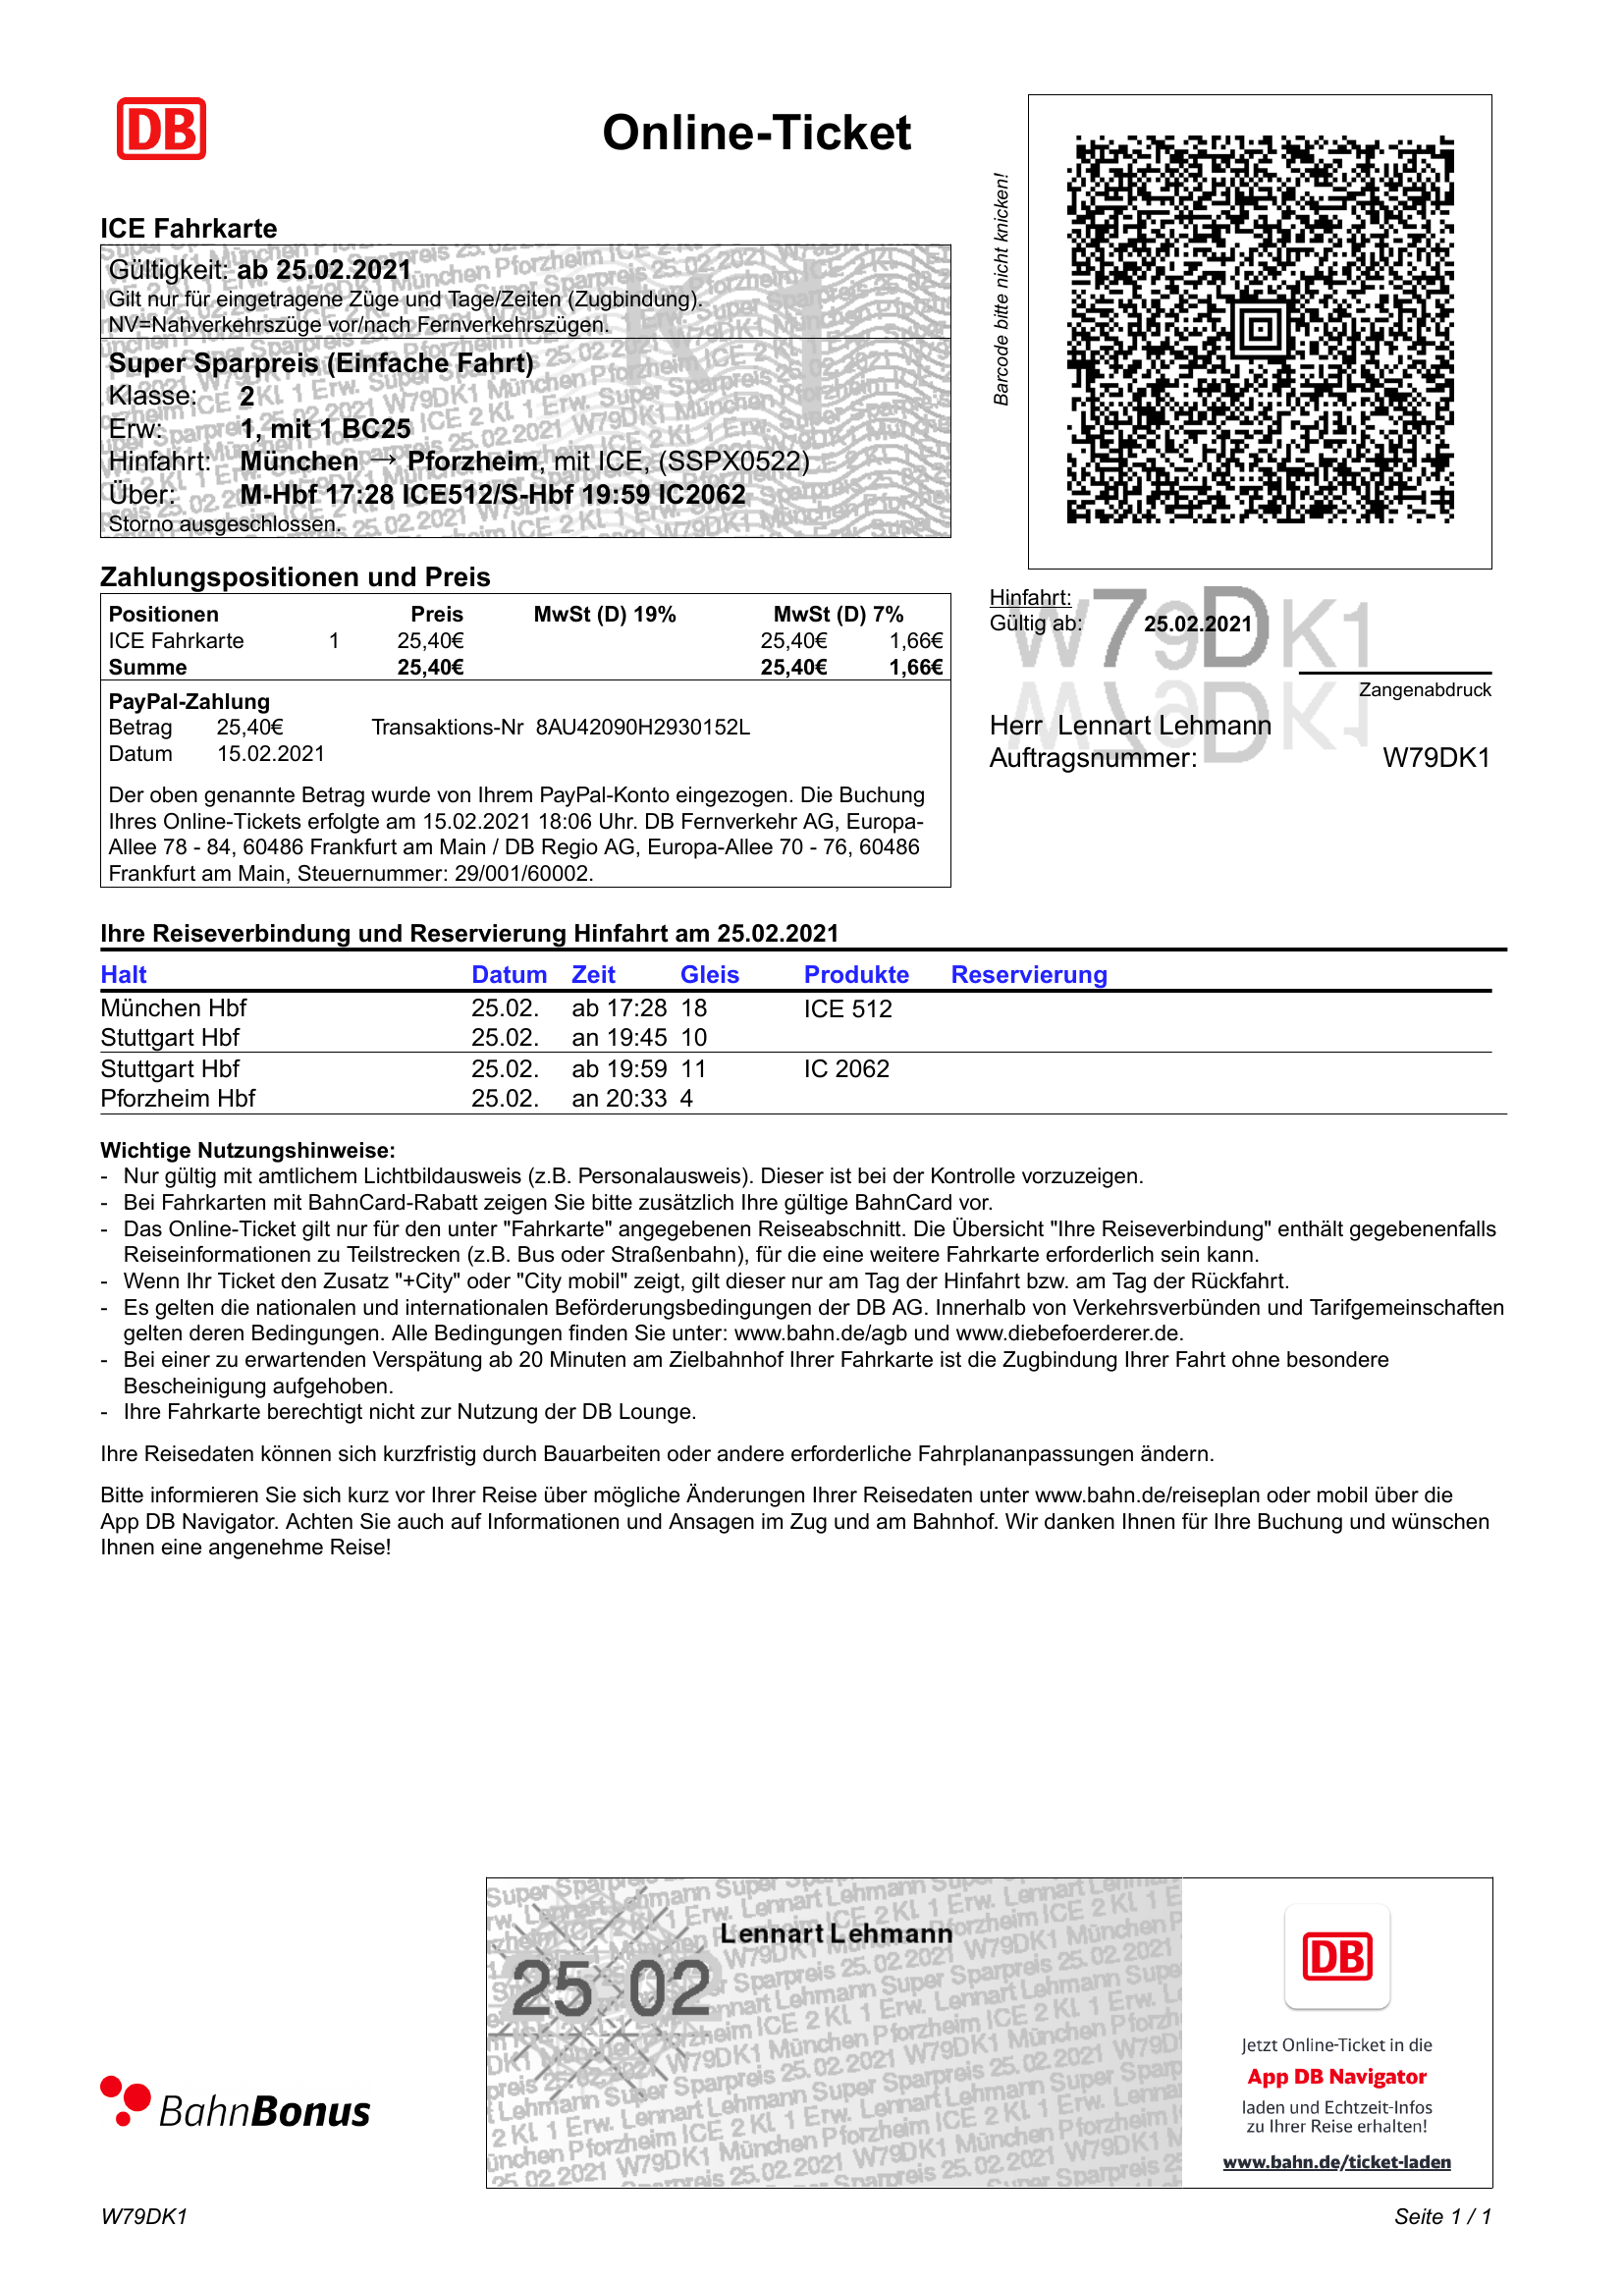

In [118]:
imgs = pdf2image.convert_from_path(files[1])
imgs[0]

## Date and Cost extraction

Let's extract the Amount of the ticket along with the date when it happened

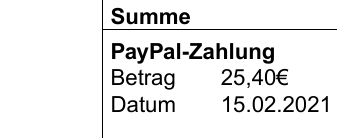

In [119]:
w, h = imgs[0].size # width and height
left = 0
right = w // 4.9
top = (h // 3.5)
bottom = h//2.9
# Crop the image to only get the relevant part of the Deutsche Bahn Invoice
price = imgs[0].crop((left, top, right, bottom))
price

In [120]:
# Run the open-source Optical Character Recognition (OCR) network on the file
costBlock = pytesseract.image_to_string(price)
print(costBlock)

 

PayPal-Zahlung
Betrag 25,40€
Datum 15.02.2021



In [121]:
# Extract the Date from the given String Block
lookoutWord = 'Datum'
dateBlock = costBlock[costBlock.find(lookoutWord) + len(lookoutWord) + 1 : -2]
dateBlock

'15.02.2021'

In [122]:
print(extractCharBlock(costBlock, 'Datum'))

 15.02.2021



In [123]:
# Extract the Amount of the given STring Block
lookoutWord = 'Betrag'
Amount = costBlock[(costBlock.find(lookoutWord) + len(lookoutWord) + 1) : (costBlock.find('€') + 1)]
Amount

'25,40€'

In [124]:
print(extractCharBlock(costBlock, 'Betrag', (costBlock.find('€') + 1)))

 25,40€


## Station Extraction 
Let's do the same stuff only for the Start and End station

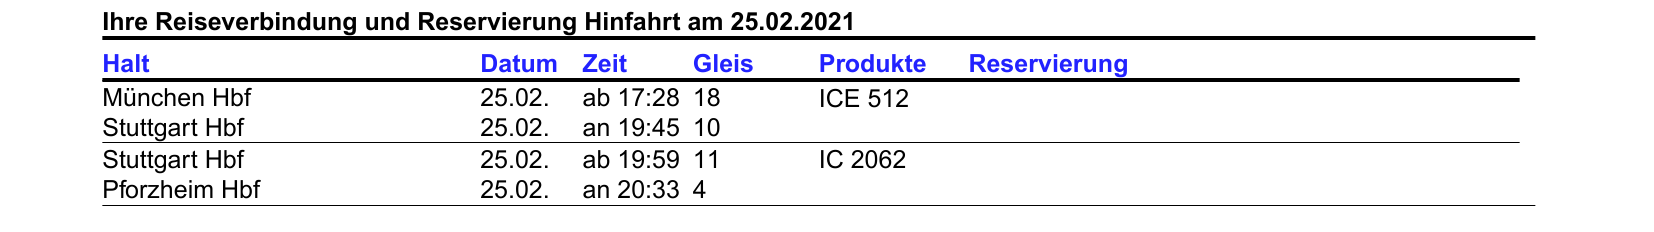

In [125]:
# Extract the Station and ride overview
w, h = imgs[0].size
left = 0
right = w
top = (h // 2.5)
bottom = h//2
stops = imgs[0].crop((left, top, right, bottom))
stops

In [126]:
# Run the OCR script to turn the image to strings
stations = pytesseract.image_to_string(stops)
print(stations)

Ihre Reiseverbindung und Reservierung Hinfahrt am 25.02.2021

 

Halt Datum Zeit Gleis Produkte __ Reservierung
Munchen Hbf 25.02. ab17:28 18 ICE 512

Stuttgart Hbf 25.02. an 19:45 10

Stuttgart Hbf 25.02. ab 19:59 11 IC 2062

Pforzheim Hbf 25.02. an 20:33 4

 



In [127]:
stations2 = stations[stations.find('Halt') :-1]
properFormat = [field for field in stations2.split('\n') if len(field) > 1]
properFormat

['Halt Datum Zeit Gleis Produkte __ Reservierung',
 'Munchen Hbf 25.02. ab17:28 18 ICE 512',
 'Stuttgart Hbf 25.02. an 19:45 10',
 'Stuttgart Hbf 25.02. ab 19:59 11 IC 2062',
 'Pforzheim Hbf 25.02. an 20:33 4']

In [128]:
format = extractCharBlock(stations, 'Halt')
properFormat = [field for field in format.split('\n') if len(field) > 1]
properFormat

[' Datum Zeit Gleis Produkte __ Reservierung',
 'Munchen Hbf 25.02. ab17:28 18 ICE 512',
 'Stuttgart Hbf 25.02. an 19:45 10',
 'Stuttgart Hbf 25.02. ab 19:59 11 IC 2062',
 'Pforzheim Hbf 25.02. an 20:33 4']

In [129]:
startStation = properFormat[1][: properFormat[1].find('Hbf')]
startStation

'Munchen '

In [130]:
overStation = properFormat[2][: properFormat[2].find('Hbf')]
overStation

'Stuttgart '

In [131]:
endStation = properFormat[-1][: properFormat[-1].find('Hbf')]
endStation

'Pforzheim '

## Write to Excel file

dump the exracted KPIs into an Excel file and place it in an S3 Bucket

In [133]:
outputDir = os.path.join(os.getcwd(), "ExcelFile")
header = ["Datum", "Kosten", "Startbahhof", "Zwischenstation", "Endbahnhof"]
entries = [dateBlock, Amount, startStation, overStation, endStation]#['18.02.2020', '25,45€', 'Munchen ', 'Stuttgart ', 'Pforzheim ']
#entries = [[entry] for entry in entries]
entries = np.array([[entry] for entry in entries])
header, entries

(['Datum', 'Kosten', 'Startbahhof', 'Zwischenstation', 'Endbahnhof'],
 array([['15.02.2021'],
        ['25,40€'],
        ['Munchen '],
        ['Stuttgart '],
        ['Pforzheim ']], dtype='<U10'))

In [134]:
df3 = pd.DataFrame(entries.T, columns=header)
df3

,Datum,Kosten,Startbahhof,Zwischenstation,Endbahnhof
0,15.02.2021,"25,40€",Munchen,Stuttgart,Pforzheim


Create an Excel file in case this is not yet present. <br>
Otherwise read the existing Excel file and append a new row with the latest entry to it.

In [ ]:
if os.listdir(outputDir) == [] :
    print("Creating new File")
    df.to_excel(os.path.join(outputDir, "Fahrkosten.xlsx"), index=False)
else:
    print("Read existing File")
    df = pd.read_excel(os.path.join(outputDir, "Fahrkosten.xlsx"))
    entries_df = pd.DataFrame(entries.T, columns=header)
    df = pd.concat([df, entries_df], ignore_index=True)
    df.to_excel(os.path.join(outputDir, "Fahrkosten.xlsx"), index=False)
    print("Successfully updated the Excel File ")
df

In [ ]:
# install missing package with the proper Python kernel
import sys
!{sys.executable} -m pip install openpyxl

In [ ]:
df_1 = df.isin(df3.values[0])
df_1

In [ ]:
counter = 0
for i in range(len(df_1.values)):
    if False in df_1.values[i]:
        counter += 1
if counter == len(df_1.values):
    print("Entry does not exist ... appending it to the DataFrame")
    df = pd.concat([df2, df3], ignore_index=True)
else:
    print("Entry does exist ... ")

In [ ]:
df3.to_excel(os.path.join(outputDir, "Fahrkosten.xlsx"), index=False)

## Write to S3 

In [ ]:
import boto3
s3 = boto3.resource('s3')

In [ ]:
bucket_name = 'lehmanl-storer'
filename = 'Fahrkosten.xlsx'
key = 'invoiceDigitization/' + filename

In [ ]:
s3.Bucket(bucket_name).upload_file(os.path.join(outputDir, filename), key)

## Generalizing Everything

In [72]:
imgs = pdf2image.convert_from_path(files[2])
d = pytesseract.image_to_data(imgs[0], output_type=pytesseract.Output.DICT)

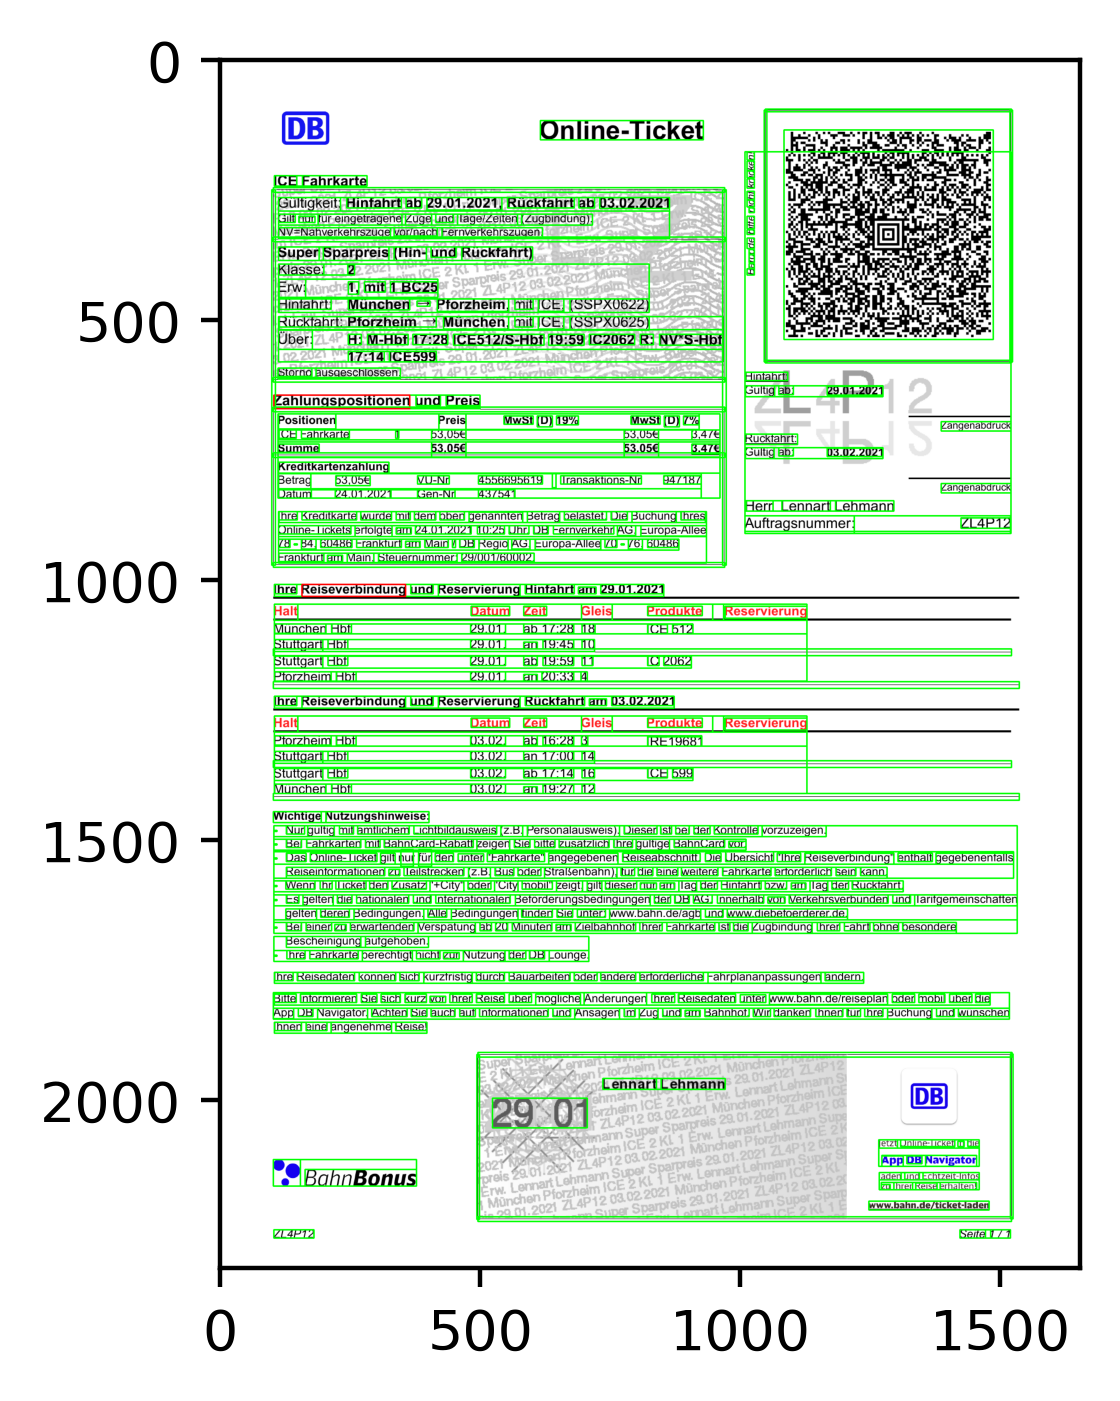

In [73]:
img2 = imgs[0].convert('RGB')
img2 = np.array(img2) 

n_boxes = len(d['level'])
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)
    if i == d['text'].index('Zahlungspositionen'):
        cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 2)
    if i == d['text'].index('Reiseverbindung'):
        cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 2)
    
# The important part - Correct BGR to RGB channel
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
# Plot
plt.imshow(img2)

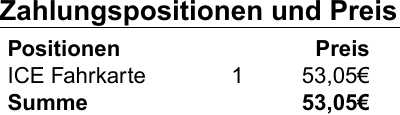

In [74]:
idx = d['text'].index('Zahlungspositionen')
idxEND = d['text'].index('Summe')
(x, y, w, h) =  (d['left'][idx], d['top'][idx], d['width'][idx], d['height'][idx])
(h2, y2) =  (d['height'][idxEND], d['top'][idxEND])
#crop_img = img[ y : y2 + h2 + 5 , x : x + 400 ]
#plt.imshow(crop_img)
image = imgs[0].crop((x, y, x+400, y2+h2+5))
image

In [75]:
netCost = pytesseract.image_to_string(image)
print(netCost)

Zahlungspositionen und Prel

 

 

Positionen Preis
ICE Fahrkarte 1 53,05€
Summe 53,05€



In [76]:
amount = netCost[ (netCost.find('Summe') + len('Summe') + 1) : -2]
amount

'53,05€'

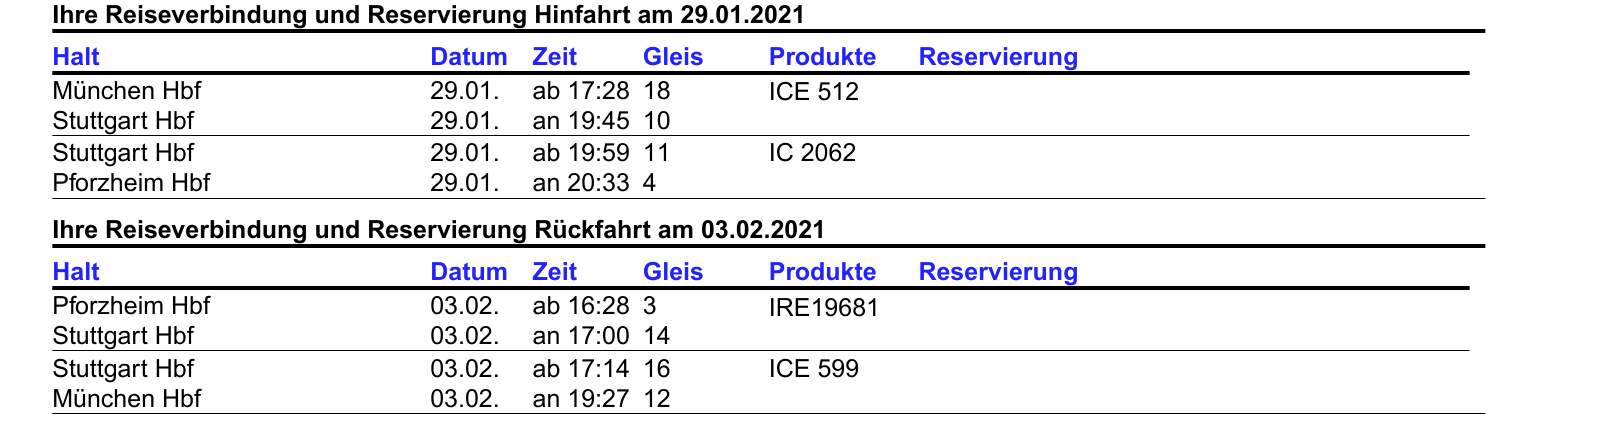

In [77]:
idx = d['text'].index('Reiseverbindung')
idxEND = d['text'].index('Wichtige')
(x, y) =  (d['left'][idx], d['top'][idx])
(h2, y2) =  (d['height'][idxEND], d['top'][idxEND])
#crop_img = img[ y - 5 : y2 , 50 : img.shape[1] ]
#plt.imshow(crop_img)
imageDest = imgs[0].crop((50, y-5, imgs[0].size[0], y2))
imageDest

In [78]:
# Run the OCR script to turn the image to strings
stations = pytesseract.image_to_string(imageDest)
print(stations)

Ihre Reiseverbindung und Reservierung Hinfahrt am 29.01.2021

 

Halt Datum Zeit Gleis Produkte __ Reservierung
Munchen Hbf 29.01. ab17:28 18 ICE 512

Stuttgart Hbf 29.01. an 19:45 10

Stuttgart Hbf 29.01. ab 19:59 11 IC 2062

Pforzheim Hbf 29.01. an 20:33 4

 

Ihre Reiseverbindung und Reservierung Rickfahrt am 03.02.2021

 

Halt Datum Zeit Gleis Produkte __ Reservierung
Pforzheim Hbf 03.02. ab 16:28 3 IRE19681

Stuttgart Hbf 03.02. _an17:00 14

Stuttgart Hbf 03.02. ab17:14 16 ICE 599

Munchen Hbf 03.02. an 19:27 12

 



In [142]:
def stations_from_list(stationsList, keyWord='Hbf'):
        stops = []
        startStation, middleStation, endStation = '', '', ''
        for i in range(len(stationsList)):
            idx = stationsList[i].find(keyWord)
            if stationsList[i][ : idx - 1] not in stops:
                stops.append(stationsList[i][ : idx - 1])
        if len(stops) > 2: # there was an chnageover, thus a middle station
            startStation 	= stops[0]
            middleStation 	= stops[1]
            endStation 	= stops[-1]
        else: # no middle station
            startStation 	= stops[0]
            endStation 	= stops[-1]
        print(startStation, middleStation, endStation)

In [145]:
def exract_Stations(croppedImg, keyWord='Halt'):
    stations = pytesseract.image_to_string(croppedImg)
    stations = extractCharBlock(stations, keyWord)
    properStations = [station for station in stations.split('\n') if len(station) > 1]
    del properStations[0]
    
    ## Check whether there was also a retunr train booked
    if any('fahrt' in entry for entry in properStations):
        returnDate = [entry[entry.find('fahrt') + 9 : entry.find('fahrt') + 19] for entry in properStations if 'fahrt' in entry][0]
        arrivalTrain = []
        returnTrain = []
        for i in range(len(properStations)): 
            if 'fahrt' in properStations[i]:
                arrivalTrain = properStations[ : i]
                returnTrain  = properStations[i+2 : ] # skip the Rueckfahrt and Halt, Datum rows and just take stations
                break
        stations_from_list(arrivalTrain)
        stations_from_list(returnTrain)
    else:
        stations_from_list(properStations)

In [146]:
exract_Stations(imageDest)

Munchen Stuttgart Pforzheim
Pforzheim Stuttgart Munchen


## Demonstartion of the Functions

In [149]:
stations = pytesseract.image_to_string(imageDest)
stations

'Ihre Reiseverbindung und Reservierung Hinfahrt am 29.01.2021\n\n \n\nHalt Datum Zeit Gleis Produkte __ Reservierung\nMunchen Hbf 29.01. ab17:28 18 ICE 512\n\nStuttgart Hbf 29.01. an 19:45 10\n\nStuttgart Hbf 29.01. ab 19:59 11 IC 2062\n\nPforzheim Hbf 29.01. an 20:33 4\n\n \n\nIhre Reiseverbindung und Reservierung Rickfahrt am 03.02.2021\n\n \n\nHalt Datum Zeit Gleis Produkte __ Reservierung\nPforzheim Hbf 03.02. ab 16:28 3 IRE19681\n\nStuttgart Hbf 03.02. _an17:00 14\n\nStuttgart Hbf 03.02. ab17:14 16 ICE 599\n\nMunchen Hbf 03.02. an 19:27 12\n\n \n\x0c'

In [150]:
# first part of the exract_Stations
word = 'Halt'
route = stations[ (stations.find(word)) : (-1)]
route = [ entry for entry in route.split('\n') if len(entry) > 1]
del route[0]
route

['Munchen Hbf 29.01. ab17:28 18 ICE 512',
 'Stuttgart Hbf 29.01. an 19:45 10',
 'Stuttgart Hbf 29.01. ab 19:59 11 IC 2062',
 'Pforzheim Hbf 29.01. an 20:33 4',
 'Ihre Reiseverbindung und Reservierung Rickfahrt am 03.02.2021',
 'Halt Datum Zeit Gleis Produkte __ Reservierung',
 'Pforzheim Hbf 03.02. ab 16:28 3 IRE19681',
 'Stuttgart Hbf 03.02. _an17:00 14',
 'Stuttgart Hbf 03.02. ab17:14 16 ICE 599',
 'Munchen Hbf 03.02. an 19:27 12']

In [151]:
#stations from list function
stops = []
for i in range(len(route)):
    idx = route[i].find('Hbf')
    if route[i][: idx - 1] not in stops:
        stops.append(route[i][: idx - 1])
stops

['Munchen',
 'Stuttgart',
 'Pforzheim',
 'Ihre Reiseverbindung und Reservierung Rickfahrt am 03.02.20',
 'Halt Datum Zeit Gleis Produkte __ Reservieru']

In [71]:
stopper = [] 
test = [stopper.append(route[i][: route[i].find('Hbf') - 1]) for i in range(len(route)) if route[i][: route[i].find('Hbf') - 1] not in stopper]
stopper

['Munchen', 'Stuttgart', 'Pforzheim']

In [152]:
returnDate = [entry[entry.find('fahrt') + len('fahrt') + 4 : entry.find('fahrt') + len('fahrt') + 14] for entry in route if 'fahrt' in entry][0]
returnDate

'03.02.2021'

In [153]:
arrivalTrain = []
returnTrain = []
if any('fahrt' in entry for entry in route):
    for i in range(len(route)):
        if 'fahrt' in route[i]:
            arrivalTrain = route[:i]
            returnTrain = route[i + 2:]
            break
arrivalTrain, returnTrain

(['Munchen Hbf 29.01. ab17:28 18 ICE 512',
  'Stuttgart Hbf 29.01. an 19:45 10',
  'Stuttgart Hbf 29.01. ab 19:59 11 IC 2062',
  'Pforzheim Hbf 29.01. an 20:33 4'],
 ['Pforzheim Hbf 03.02. ab 16:28 3 IRE19681',
  'Stuttgart Hbf 03.02. _an17:00 14',
  'Stuttgart Hbf 03.02. ab17:14 16 ICE 599',
  'Munchen Hbf 03.02. an 19:27 12'])

In [112]:
stops = []
for i in range(len(arrivalTrain)):
    idx = arrivalTrain[i].find('Hbf')
    if arrivalTrain[i][: idx - 1] not in stops:
        stops.append(arrivalTrain[i][: idx - 1])
stops

['Munchen', 'Stuttgart', 'Pforzheim']

In [113]:
stops = []
for i in range(len(returnTrain)):
    idx = returnTrain[i].find('Hbf')
    if returnTrain[i][: idx - 1] not in stops:
        stops.append(returnTrain[i][: idx - 1])
stops

['Pforzheim', 'Stuttgart', 'Munchen']

## DataFrame Magic

In [162]:
header = ["Datum", "Kosten", "Startbahhof", "Zwischenstation", "Endbahnhof"]
entries = stops[:3]
entries.append(dateBlock)
entries.append(Amount)
entries = np.array([[entry] for entry in entries])
df = pd.DataFrame(entries.T, columns=header)
df

,Datum,Kosten,Startbahhof,Zwischenstation,Endbahnhof
0,Munchen,Stuttgart,Pforzheim,15.02.2021,"25,40€"


In [169]:
test = ['18.02.2020', '25,45€', 'Munchen ', 'Stuttgart ', 'Pforzheim ']
test = np.array([[entry] for entry in test])
test.T

array([['18.02.2020', '25,45€', 'Munchen ', 'Stuttgart ', 'Pforzheim ']],
      dtype='<U10')

In [178]:
arr = np.vstack([entries.T, test.T])
df2 = pd.DataFrame(arr, columns=header)
df2

,Datum,Kosten,Startbahhof,Zwischenstation,Endbahnhof
0,Munchen,Stuttgart,Pforzheim,15.02.2021,"25,40€"
1,18.02.2020,"25,45€",Munchen,Stuttgart,Pforzheim


In [179]:
entries

array([['Munchen'],
       ['Stuttgart'],
       ['Pforzheim'],
       ['15.02.2021'],
       ['25,40€']], dtype='<U10')

In [182]:
a = np.array([ ['Mun'], [99], [33], [332], [11] ])
a.T

array([['Mun', '99', '33', '332', '11']], dtype='<U3')

## Class Usage

1.) Create Class with path/to/invoices <br/>
2.) Build And Set Directories if not existent <br/>
3.) Extract Files<br/>
3.) ConvertPDF2Image<br/>
4.) Image To Data to get the cropped Images (priceImg, destinationImg)<br/>
5.) Extract Key Information returns a DataFrame<br/>
6.) Add Delta in DataFrames<br/>
7.) Write to S3 bucket<br/>

In [ ]:
invoicing = InvoiceDigitization(os.path.join(os.getcwd(), 'Invoice'))
invoicing.Build_And_Set_Directories()
invoicing.Extract_Files()

final_df = pd.read_excel(os.path.join(invoicing.outputDir, "Fahrkosten.xlsx"))
for i in range(len(invoicing.invoices)):
    invoicing.invoiceImgs = invoicing.Convert_PDF2Image(invoicing.invoices[i])
    invoicing.Image_To_Data(invoicing.invoiceImgs[0])
    df = invoicing.Extract_Key_Information()
    final_df = invoicing.Add_Delta_In_Dataframes(final_df, df, True)
print(final_df)
invoicing.Write_To_S3("Fahrkosten.xlsx")

## Showing the Image
#invoicing.destinationImg.show()
#invoicing.priceImg.show()
#invoicing.invoiceImgs[0].show()